In [1]:
# Jupyter Notebook Setup Cell
# ===========================
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time
import sys
import matplotlib.pyplot as plt

# For nicer plots in the notebook
%matplotlib inline

# Helper function for approximate memory usage in bytes for a SciPy sparse matrix
def memory_usage_sparse(sparse_mat):
    """
    Returns an approximate memory usage (in bytes) for a sparse matrix.
    We sum up the nbytes of .data, .indices, .indptr if they exist.
    This does not capture all overhead but is a good approximation.
    """
    total = 0
    if hasattr(sparse_mat, 'data'):
        total += sparse_mat.data.nbytes
    if hasattr(sparse_mat, 'indices'):
        total += sparse_mat.indices.nbytes
    if hasattr(sparse_mat, 'indptr'):
        total += sparse_mat.indptr.nbytes
    return total

# Helper function for memory usage of a dense matrix
def memory_usage_dense(A):
    return A.nbytes
    
# Define the sparse formats:
sparse_formats = {
    'DOK': sp.dok_matrix,
    'LIL': sp.lil_matrix,
    'COO': sp.coo_matrix,
    'CSR': sp.csr_matrix,
    'CSC': sp.csc_matrix,
    'BSR': lambda x: sp.bsr_matrix(x, blocksize=(1,1))
}


# Introduction

This notebook explores how to create, manipulate and store **tri-diagonal matrices** in different ways:

1. **Dense storage** (a standard `numpy.ndarray`).
2. Several **sparse storage** formats:
   - **DOK (Dictionary of keys)**
   - **LIL (List of lists)**
   - **COO (Coordinate)**
   - **CSR (Compressed Sparse Row)**
   - **CSC (Compressed Sparse Column)**.
   - **BSR (Block Sparse Row)**


No ipywidgets. Created a 50 x 50 dense tri-diagonal matrix.
Memory usage (dense) = 20000 bytes (~0.020 MB)


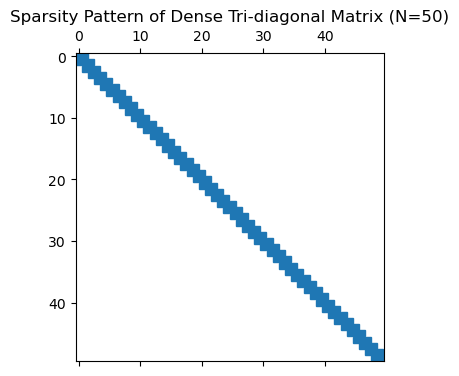

In [2]:
def create_tridiagonal_matrix_dense(N, main_val=2.0, off_val=-1.0):
    """
    Creates an NxN tri-diagonal dense matrix with:
     - main diagonal set to main_val
     - sub-diagonal and super-diagonal set to off_val.
    Returns a dense numpy array.
    """
    A = np.zeros((N, N), dtype=np.float64)
    np.fill_diagonal(A, main_val)
    np.fill_diagonal(A[1:], off_val)   # sub-diagonal
    np.fill_diagonal(A[:,1:], off_val) # super-diagonal
    return A

N = 50
A_dense = create_tridiagonal_matrix_dense(N)
print(f"No ipywidgets. Created a {N} x {N} dense tri-diagonal matrix.")
print(f"Memory usage (dense) = {memory_usage_dense(A_dense)} bytes (~{memory_usage_dense(A_dense)/1e6:.3f} MB)")
plt.figure(figsize=(4,4))
plt.spy(A_dense, markersize=5)
plt.title(f"Sparsity Pattern of Dense Tri-diagonal Matrix (N={N})")
plt.show()

# Sparse Format Explanations

## 1. DOK (Dictionary of Keys)

**How it stores data:**
- Internally uses a Python dictionary where each **key** is a coordinate `(row, col)` and each **value** is the non-zero entry at that position.  
- Example: `{(0, 0): 2.0, (1, 0): -1.0, (0, 1): -1.0, ... }`

**Advantages:**
- Great for **incremental construction** or modifying a sparse matrix (e.g., adding one non-zero element at a time).
- Very intuitive for assembling a matrix in a piecewise fashion.

**Disadvantages:**
- Not very efficient for arithmetic or repeated operations on large matrices (slow matrix-vector multiply, etc.).
- Extra dictionary overhead can become significant for large-scale problems.

---

## 2. LIL (List of Lists)

**How it stores data:**
- Each row of the matrix is stored as a list (or sometimes two lists: one for column indices and one for values).  
- Conceptually: `[[ (col_idx1, val1), (col_idx2, val2), ... ],  # row 0
                 [ (col_idx1, val1), (col_idx2, val2), ... ],  # row 1
                 ...
                ]`

**Advantages:**
- Also good for **incremental building** of the matrix (especially row by row).
- Easy to modify rows: append elements, remove elements, etc.

**Disadvantages:**
- Not as fast for large-scale arithmetic once the matrix is built.
- Typically converted to CSR or CSC for efficient computations.

---

## 3. COO (Coordinate List)

**How it stores data:**
- Maintains **three arrays**: one for row indices, one for column indices, and one for the corresponding values.  
- If you have \(k\) non-zeros, you’ll have arrays of length \(k\):
  - `row = [r1, r2, r3, ...]`
  - `col = [c1, c2, c3, ...]`
  - `data = [v1, v2, v3, ...]`

**Advantages:**
- Simple and flexible for constructing a matrix at once.
- Often used as an **intermediate** format before converting to CSR/CSC.
- Easy to **merge** or **concatenate** multiple COO matrices.

**Disadvantages:**
- Not efficient for arithmetic or repeated operations unless converted.
- Duplicate entries can occur if you’re not careful (which need to be coalesced).

---

## 4. CSR (Compressed Sparse Row)

**How it stores data:**
- Stores row start positions in a compressed manner. Typically:
  - `data`: all non-zero values in a single array.
  - `indices`: the corresponding column indices for each entry in `data`.
  - `indptr`: an array of length `n_rows + 1`, where `indptr[i]` points to the index in `data` that starts row `i`.
- Example for 4×4 matrix:
  - `data = [2.0, -1.0, -1.0, 2.0, -1.0, ...]`
  - `indices = [0, 1, 0, 1, 2, ...]`
  - `indptr = [0, 2, 4, 6, ...]`

**Advantages:**
- Excellent for **fast arithmetic** (matrix-vector multiplication, etc.).
- Row slicing is efficient (easy to extract row `i` by looking between `indptr[i]` and `indptr[i+1]`).

**Disadvantages:**
- Column slicing is slower (you have to scan multiple rows).
- More complex to build incrementally; typically constructed from COO or LIL.

---

## 5. CSC (Compressed Sparse Column)

**How it stores data:**
- Very similar to CSR, except **columns** are compressed instead of rows.
  - `data`: non-zero values in a single array.
  - `indices`: now represents the row indices for each non-zero in `data`.
  - `indptr`: an array of length `n_cols + 1`, marking the start of each column in `data`.

**Advantages:**
- Efficient for **column slicing** and certain operations/solvers that prefer column-based access (e.g., some linear algebra routines).
- Maintains the same fundamental space/time efficiency as CSR in arithmetic.

**Disadvantages:**
- Row slicing is slower.
- Also not convenient for incremental assembly (best constructed after building in COO/LIL or after transposing a CSR matrix).

---

## 6. BSR (Block Sparse Row)

**How it stores data:**
- A variant of CSR that stores **blocks** of non-zero entries instead of individual values.  
- Each entry in `data` is a small dense sub-block.  
- Typically accompanied by metadata specifying the block size (e.g. `blocksize=(m, n)`).

**Advantages:**
- Great if your matrix has a **known block structure** (for example, each block is a small dense matrix), reducing overhead when each block is processed as a unit.
- Often provides faster block-based operations in iterative solvers when the block patterns are natural (like PDE problems with multiple variables per node).

**Disadvantages:**
- Overkill for truly element-wise sparse data with no natural block structure.
- More complex index management if your block structure doesn’t evenly divide rows/columns.

---

**In summary**, each format has its strengths and weaknesses:
- **DOK, LIL** are ideal for building/modifying sparse matrices entry-by-entry or row-by-row.  
- **COO** is good for one-shot assembly (or merging data) before converting to more efficient formats.  
- **CSR, CSC** are the “workhorse” formats for most sparse linear algebra (fast arithmetic, memory efficient).  
- **BSR** is a specialized case of CSR for block-structured matrices, which can be advantageous in certain PDE or finite-element contexts.

Sparse Formats - Memory Usage
DOK: 0 bytes (~0.000000 MB)
LIL: 400 bytes (~0.000400 MB)
COO: 1184 bytes (~0.001184 MB)
CSR: 1980 bytes (~0.001980 MB)
CSC: 1980 bytes (~0.001980 MB)
BSR: 1980 bytes (~0.001980 MB)


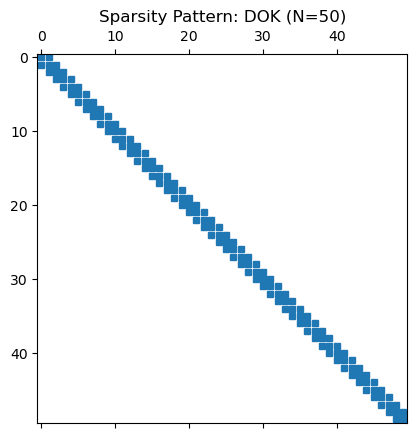

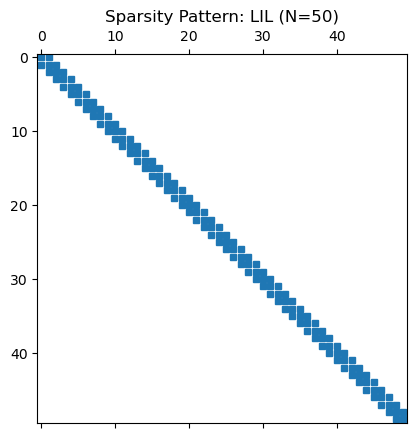

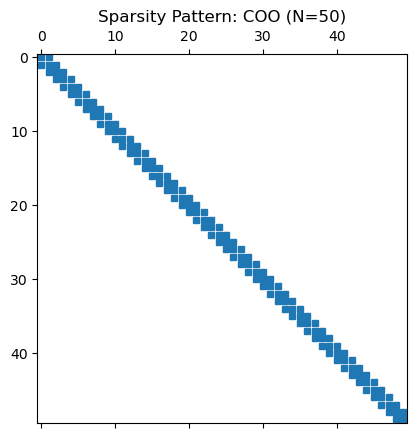

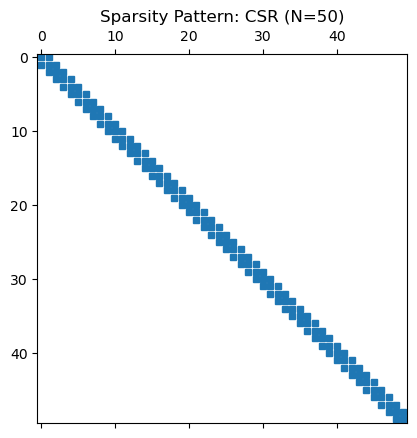

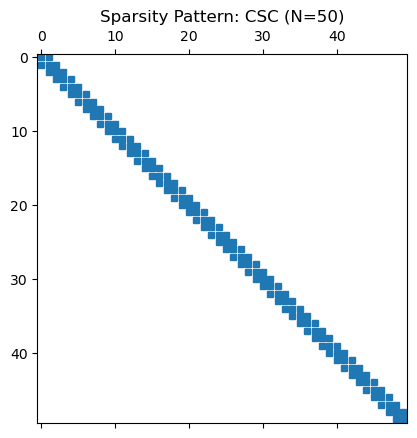

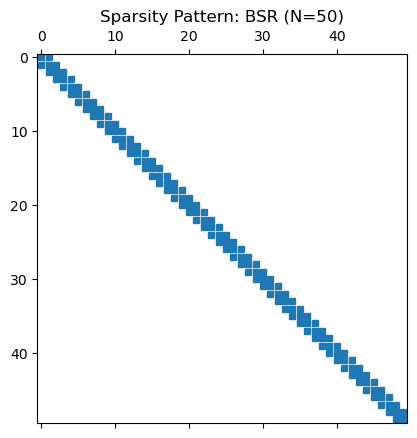

In [3]:
# Convert to various sparse formats
A_dok = sp.dok_matrix(A_dense)
A_lil = sp.lil_matrix(A_dense)
A_coo = sp.coo_matrix(A_dense)
A_csr = sp.csr_matrix(A_dense)
A_csc = sp.csc_matrix(A_dense)
A_bsr = sp.bsr_matrix(A_dense, blocksize=(1,1))  # blocksize=(1,1) for tri-diagonal

formats = {
    'DOK': A_dok,
    'LIL': A_lil,
    'COO': A_coo,
    'CSR': A_csr,
    'CSC': A_csc,
    'BSR': A_bsr
}

# Print memory usage
print("Sparse Formats - Memory Usage")
for fmt_name, sparse_mat in formats.items():
    mem = memory_usage_sparse(sparse_mat)
    print(f"{fmt_name}: {mem} bytes (~{mem/1e6:.6f} MB)")

# Visualize each format with plt.spy() in separate figures
for fmt_name, sparse_mat in formats.items():
    plt.figure()
    plt.spy(sparse_mat, markersize=5)
    plt.title(f"Sparsity Pattern: {fmt_name} (N={N})")
    plt.show()

In [15]:
N_values = np.linspace(10, 20, 1000, dtype=int).tolist()

dense_mem = []
dense_times_sq_mat = []   # time to do A_dense @ A_dense
dense_times_sq_eigs = []  # time to do w_dense ** 2

sparse_mem = {fmt: [] for fmt in sparse_formats}
sparse_times_sq_mat = {fmt: [] for fmt in sparse_formats}

for N in N_values:
    # 1) Create a tri-diagonal dense matrix of size NxN
    A_dense = create_tridiagonal_matrix_dense(N)
    
    # Dense memory usage
    mem_d = memory_usage_dense(A_dense)
    dense_mem.append(mem_d)
    
    # 2) Timing: squaring the dense matrix
    t0 = time.time()
    A2_dense = A_dense @ A_dense
    t1 = time.time()
    dense_times_sq_mat.append(t1 - t0)
    
    # 3) Timing: squaring the eigenvalues (first compute them)
    w_dense, v_dense = np.linalg.eig(A_dense)
    t0 = time.time()
    w_sq = w_dense ** 2
    t1 = time.time()
    dense_times_sq_eigs.append(t1 - t0)
    
    # 4) For each sparse format, measure memory usage & timing for A_sp @ A_sp
    for fmt_name, constructor in sparse_formats.items():
        
        # Convert from dense to chosen sparse format
        A_sp = constructor(A_dense)
        
        # Memory usage in that format
        mem_s = memory_usage_sparse(A_sp)
        sparse_mem[fmt_name].append(mem_s)
        
        # Time to compute A_sp^2
        t0 = time.time()
        A2_sp = A_sp @ A_sp
        t1 = time.time()
        sparse_times_sq_mat[fmt_name].append(t1 - t0)

# Convert results to NumPy arrays (useful for plotting or further analysis)
dense_mem = np.array(dense_mem, dtype=float)
dense_times_sq_mat = np.array(dense_times_sq_mat, dtype=float)
dense_times_sq_eigs = np.array(dense_times_sq_eigs, dtype=float)

for fmt_name in sparse_formats:
    sparse_mem[fmt_name]          = np.array(sparse_mem[fmt_name], dtype=float)
    sparse_times_sq_mat[fmt_name] = np.array(sparse_times_sq_mat[fmt_name], dtype=float)

print("Completed data collection")

Completed data collection


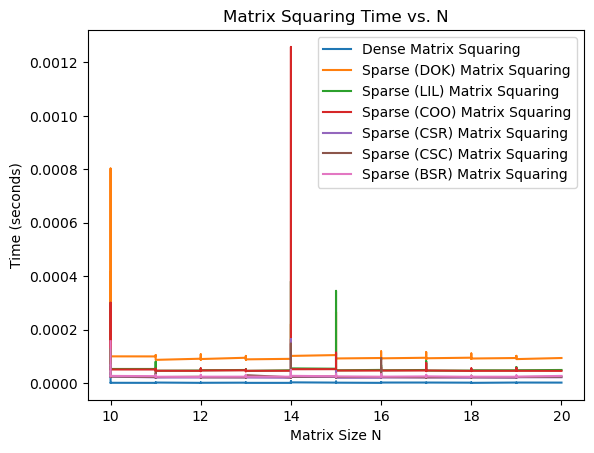

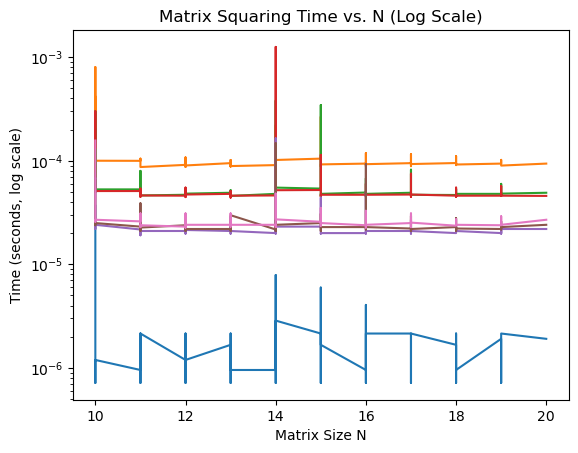

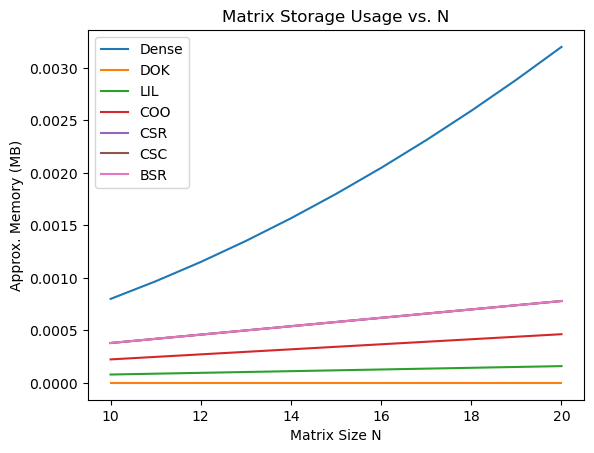

In [19]:
# Plot 1: Matrix Squaring Time (Dense vs. Sparse)
plt.figure()
plt.plot(N_values, dense_times_sq_mat, label='Dense Matrix Squaring')
for fmt_name in sparse_formats:
    plt.plot(N_values, sparse_times_sq_mat[fmt_name], label=f'Sparse ({fmt_name}) Matrix Squaring')
plt.xlabel('Matrix Size N')
plt.ylabel('Time (seconds)')
plt.title('Matrix Squaring Time vs. N')
plt.legend()
plt.show()

# Plot 2: Matrix Squaring Time (Dense vs. Sparse) Log Plot
plt.figure()
plt.semilogy(N_values, dense_times_sq_mat, label='Dense Matrix Squaring')
for fmt_name in sparse_formats:
    plt.semilogy(N_values, sparse_times_sq_mat[fmt_name], label=f'Sparse ({fmt_name}) Matrix Squaring')
plt.xlabel('Matrix Size N')
plt.ylabel('Time (seconds, log scale)')
plt.title('Matrix Squaring Time vs. N (Log Scale)')
plt.show()

# Plot 3: Matrix Storage Usage for the original matrix (Dense vs. Sparse)
plt.figure()
plt.plot(N_values, dense_mem / 1e6, label='Dense')
for fmt_name in sparse_formats:
    plt.plot(N_values, sparse_mem[fmt_name] / 1e6, label=fmt_name)
plt.xlabel('Matrix Size N')
plt.ylabel('Approx. Memory (MB)')
plt.title('Matrix Storage Usage vs. N')
plt.legend()
plt.show()

# Solving Sparse Linear Systems

In many applications, you need to solve linear systems of the form

\[
  A\,x = b,
\]

where \(A\) is a sparse matrix. SciPy provides several methods to do this efficiently:

- **`spsolve(A, b[, permc_spec, use_umfpack])`**:  
  Directly solves \(A\, x = b\) using sparse LU factorization.

- **`spsolve_triangular(A, b[, lower, ...])`**:  
  Solves \(A\, x = b\) when \(A\) is triangular. Specify `lower=True` for a lower-triangular matrix.

- **`factorized(A)`**:  
  Factorizes \(A\) and returns a function that can quickly solve \(A\, x = b\) for different right-hand sides \(b\).  
  This is especially useful when solving many systems with the same \(A\) (e.g., in eigenvector computations or iterative methods).

Below is an example demonstrating these methods.

In [24]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
from scipy.sparse import tril
# --- Example: Solve A x = b ---
N = 10 
A_dense = create_tridiagonal_matrix_dense(N)
A = sp.csr_matrix(A_dense)  # Convert dense matrix to CSR format
b = np.random.rand(N)

# Method 1: Direct sparse solve using spsolve
x_direct = spla.spsolve(A, b)

# Method 2: If A is triangular, use spsolve_triangular.
L = tril(A).tocsr()
x_triangular = spla.spsolve_triangular(L, b, lower=True)

# Method 3: Factorize A once, then solve for many right-hand sides.
solve_A = spla.factorized(A)
x_factorized = solve_A(b)
# Now you can reuse solve_A(b2), solve_A(b3), etc.

print("Solution using spsolve:          ", x_direct)
print("Solution using spsolve_triangular:", x_triangular)
print("Solution using factorized:      ", x_factorized)
# Print the CSR matrix as dense (just for demonstration)
print("A (CSR) as dense:\n", A.toarray())
print("L (lower portion of A) as dense:\n", L.toarray())


Solution using spsolve:           [2.47792015 4.62704498 6.45927962 7.77727338 8.53643547 8.75074862
 8.05425015 6.87914007 4.90245199 2.70485743]
Solution using spsolve_triangular: [0.16439766 0.24064392 0.37744241 0.46813703 0.50649299 0.70865231
 0.59363195 0.69760498 0.45925573 0.4832593 ]
Solution using factorized:       [2.47792015 4.62704498 6.45927962 7.77727338 8.53643547 8.75074862
 8.05425015 6.87914007 4.90245199 2.70485743]
A (CSR) as dense:
 [[ 2. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  2. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  2. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  2. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  2. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  2. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  2. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  2. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  2. -1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.  2.]]
L (lower portion of A) as dense:
 [[ 2.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  2.  0.  0.  0.  0.  0.  0

/opt/anaconda3/lib/python3.12/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
